In [1]:
import sys

print(sys.executable)

/Users/supernova/miniconda3/envs/360/bin/python3


In [2]:
import logging

# make sure INFO (or DEBUG) logs go to your console
logging.basicConfig(level=logging.INFO)
logging.getLogger("detectron2.engine.defaults").setLevel(logging.INFO)

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets.coco import load_coco_json

# 1. Define your “real” COCO IDs and your class names:
COCO_IDS = [0, 1, 2, 3, 5, 7, 9]
CLASS_NAMES = ["person", "bicycle", "car", "motorbike", "bus", "truck", "traffic light"]
# build a quick reverse‐map: COCO_id → contiguous (0–6)
COCO2CONT = {c:i for i,c in enumerate(COCO_IDS)}
# 2. Register your dataset, telling Detectron2 how to map
#    your JSON’s category_id (which you’ve numbered 1–7) back
#    to the real COCO IDs above.
def register_my_dataset(name, json_file, image_root):
    # build a map:  json_id (1–7)  →  contiguous id (0–6)

    dataset_id_to_contiguous = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}
    MetadataCatalog.get("myval7").set(
        json_file=json_file,
        image_root=image_root,
        evaluator_type="coco",
        thing_classes=CLASS_NAMES,
        thing_dataset_id_to_contiguous_id=dataset_id_to_contiguous,
    )
    DatasetCatalog.register(
        name,
        lambda: load_coco_json(json_file, image_root, name),
    )

register_my_dataset(
    "my_val",
    "/Users/supernova/360_object_tracking/video1/COCO/annotations/instances_default.json",
    "/Users/supernova/360_object_tracking/video1/COCO/val"
)




AssertionError: Dataset 'my_val' is already registered!

In [6]:
# Tell Detectron2 how many classes and what their names are:
MetadataCatalog.get("my_val").thing_classes = ['person', 'bicycle', 'car', 'motorbike', 'bus', 'truck', 'traffic light']
# Now the metadata has been populated:
print(MetadataCatalog.get("my_val").thing_classes)
# → ['person', 'bicycle', 'car', 'motorbike', 'bus', 'truck', 'traffic light']

['person', 'bicycle', 'car', 'motorbike', 'bus', 'truck', 'traffic light']


In [7]:
from detectron2.engine import DefaultPredictor
from detectron2.data import build_detection_test_loader
from detectron2 import model_zoo
from detectron2.config import get_cfg
import torch

cfg = get_cfg()

input_size=1280
score_threshold=0.4
# nms_threshold=0.45

# choose a model from detectron2's model zoo
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
)

cfg.INPUT.MIN_SIZE_TEST = input_size  # set the size of the input images
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (
    score_threshold  # set the threshold of the confidence score
)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7
# cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = nms_threshold  # set the NMS threshold

# set the device to use (GPU or CPU)
if torch.cuda.is_available():
    cfg.MODEL.DEVICE = "cuda"
else:
    cfg.MODEL.DEVICE = "cpu"

    # only work on apple m1 mac
    # cfg.MODEL.DEVICE = 'mps'

# create a predictor instance with the config above
predictor_faster_RCNN = DefaultPredictor(cfg)

# Build a DataLoader for the "my_val" split
val_loader = build_detection_test_loader(cfg, "my_val")

INFO:fvcore.common.checkpoint:[Checkpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...
INFO:iopath.common.file_io:URL https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl cached in /Users/supernova/.torch/iopath_cache/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl
INFO:fvcore.common.checkpoint:Reading a file from 'Detectron2 Model Zoo'
INFO:detectron2.data.datasets.coco:Loaded 420 images in COCO format from /Users/supernova/360_object_tracking/video1/COCO/annotations/instances_default.json
INFO:detectron2.data.dataset_mapper:[DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1280, 1280), max_size=1333, sample_style='choice')]
INFO:detectron2.data.common:Serializing 420 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized data

In [8]:
# 1) Grab one batch
batch = next(iter(val_loader))  # yields a list of dicts, one per image

# 2) Inspect the keys of the first example
example = batch[0]
print(example)

print(example.keys())


{'file_name': '/Users/supernova/360_object_tracking/video1/COCO/val/frame_000000.PNG', 'height': 2688, 'width': 5376, 'image_id': 1, 'image': tensor([[[252, 252, 252,  ..., 253, 253, 253],
         [252, 252, 252,  ..., 253, 253, 253],
         [253, 253, 253,  ..., 253, 253, 253],
         ...,
         [ 37,  36,  35,  ...,  41,  41,  40],
         [ 28,  28,  28,  ...,  31,  30,  30],
         [ 18,  18,  19,  ...,  19,  19,  19]],

        [[253, 253, 253,  ..., 254, 254, 254],
         [253, 253, 253,  ..., 254, 254, 254],
         [254, 254, 254,  ..., 254, 254, 254],
         ...,
         [ 28,  27,  26,  ...,  32,  31,  30],
         [ 21,  21,  20,  ...,  23,  23,  23],
         [ 12,  13,  13,  ...,  13,  13,  13]],

        [[248, 248, 248,  ..., 249, 249, 249],
         [248, 248, 248,  ..., 249, 249, 249],
         [249, 249, 249,  ..., 250, 250, 250],
         ...,
         [ 30,  29,  27,  ...,  33,  32,  31],
         [ 21,  21,  20,  ...,  23,  23,  23],
         [ 13

INFO:detectron2.data.datasets.coco:Loaded 420 images in COCO format from /Users/supernova/360_object_tracking/video1/COCO/annotations/instances_default.json


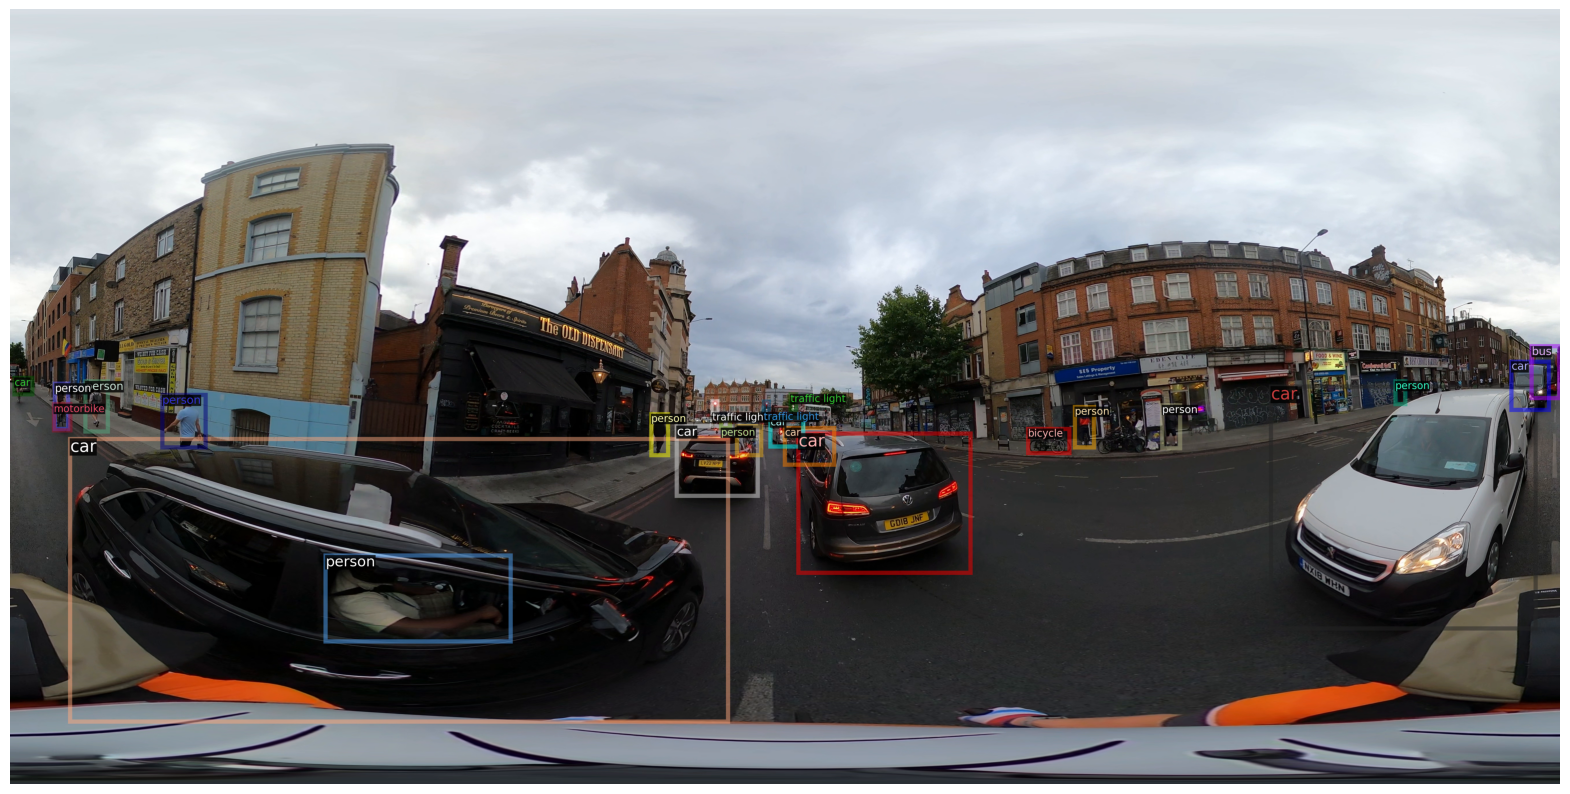

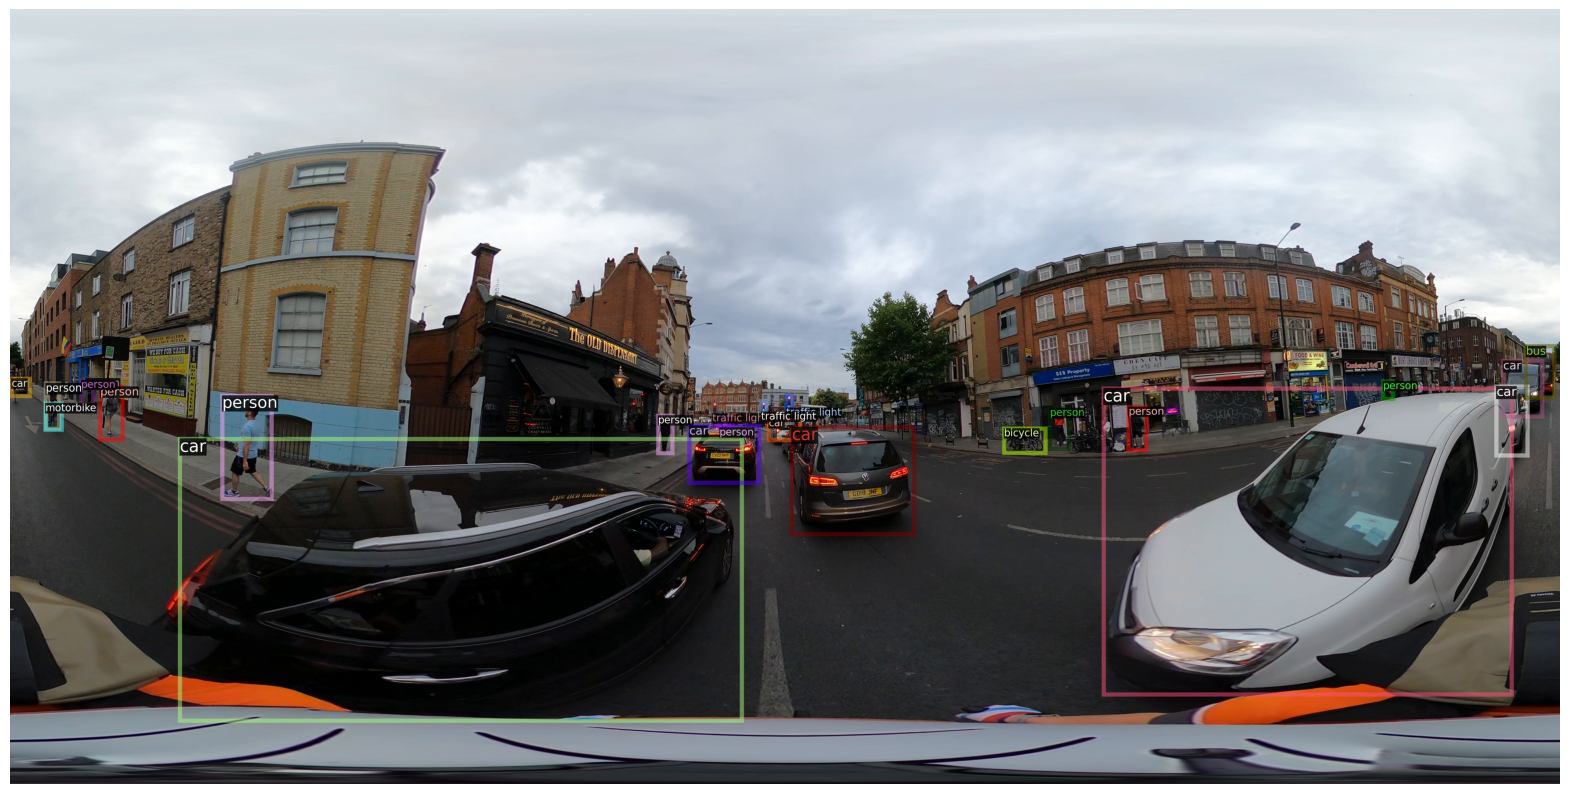

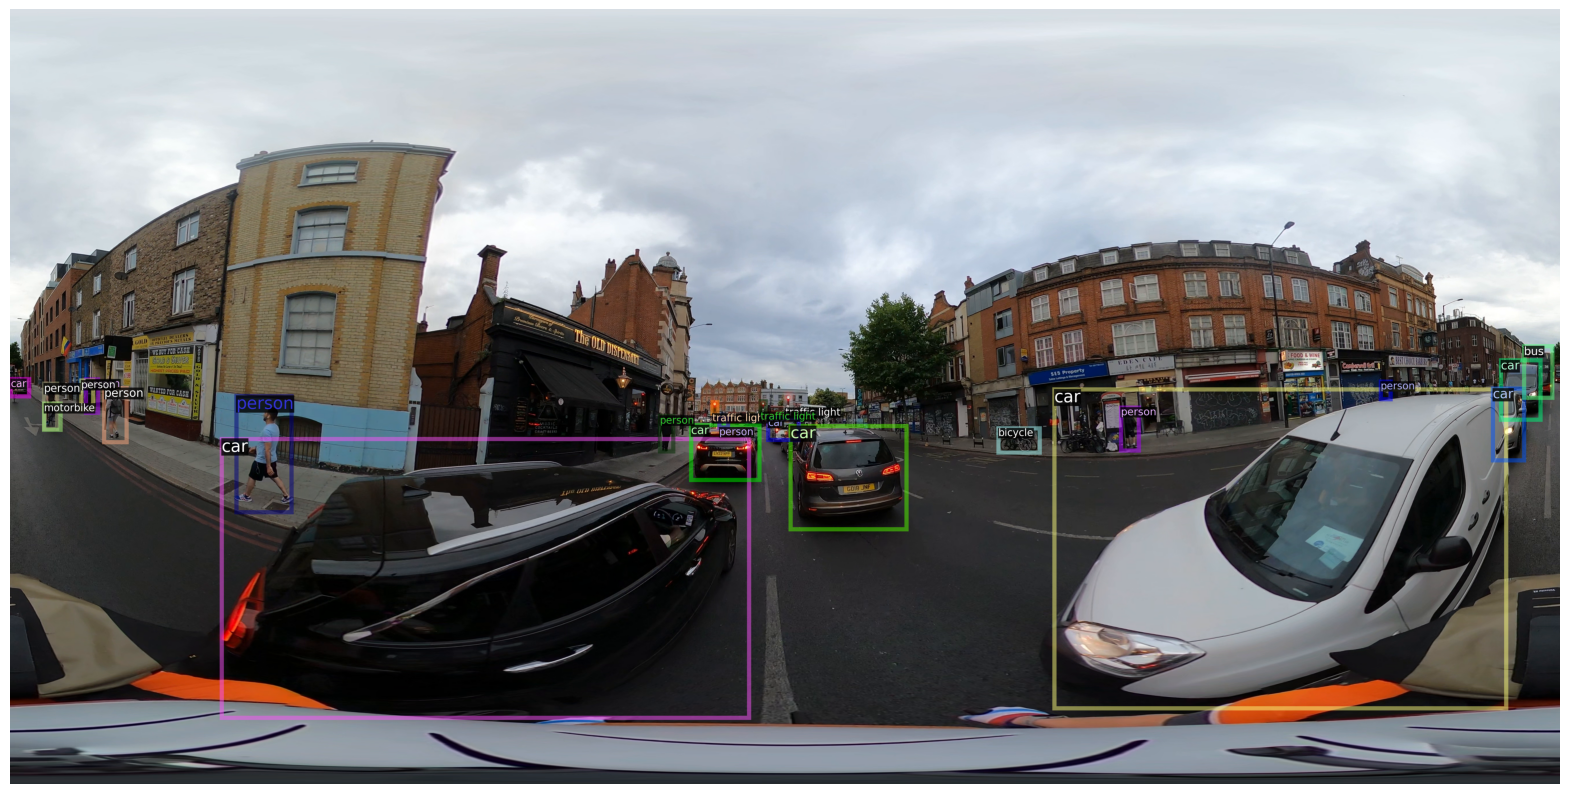

In [9]:
from detectron2.data import DatasetCatalog
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import random
import cv2

# 1) load the raw dicts
dataset_dicts = DatasetCatalog.get("my_val")

# 2) sample 3 at random
samples = random.sample(dataset_dicts, 3)

# 3) visualize each
metadata = MetadataCatalog.get("my_val")
for d in samples:
    img = cv2.imread(d["file_name"])                 # BGR uint8
    vis = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
    out = vis.draw_dataset_dict(d)                   # draws d["annotations"]
    out_rgb = out.get_image()                        # RGB H×W×3

    plt.figure(figsize=(20,12))
    plt.imshow(out_rgb)
    plt.axis("off")
    plt.show()

In [10]:
from detectron2.evaluation import COCOEvaluator
# 4) subclass COCOEvaluator to filter & remap on the fly

# class FilterAndRemapCOCOEvaluator(COCOEvaluator):
#     def process(self, inputs, outputs):
#         # inputs: list of dicts, outputs: list of dicts with "instances"
#         new_inputs, new_outputs = [], []
#         for inp, out in zip(inputs, outputs):
#             inst = out["instances"].to("cpu")
#             # keep only predictions whose class is in our COCO_IDS
#             keep_mask = [(c in COCO_IDS) for c in inst.pred_classes.tolist()]
#             if not any(keep_mask):
#                 # no valid preds for this image → skip
#                 continue
#             inst = inst[keep_mask]
#             # remap class indices: e.g. if pred_classes=[0,5,9], new → [0,4,6]
#             remapped = [COCO2CONT[int(c)] for c in inst.pred_classes.tolist()]
#             inst.pred_classes = torch.tensor(remapped)
#             out["instances"] = inst
#             new_inputs.append(inp)
#             new_outputs.append(out)
#
#         # now call the parent with filtered/remapped lists
#         super().process(new_inputs, new_outputs)

# You can specify which tasks to compute; by default it infers from dataset (bbox, segm, keypoints…)
evaluator = COCOEvaluator(
    dataset_name="my_val",   # the name you registered
    tasks=("bbox",),         # e.g., "bbox", "segm", or ("bbox", "segm")
    distributed=False,       # set True if using multi-GPU
    output_dir="./output"    # where to dump JSON results & summaries
)

INFO:detectron2.evaluation.coco_evaluation:Trying to convert 'my_val' to COCO format ...
INFO:detectron2.data.datasets.coco:Converting annotations of dataset 'my_val' to COCO format ...)
INFO:detectron2.data.datasets.coco:Loaded 420 images in COCO format from /Users/supernova/360_object_tracking/video1/COCO/annotations/instances_default.json
INFO:detectron2.data.datasets.coco:Converting dataset dicts into COCO format
INFO:detectron2.data.datasets.coco:Conversion finished, #images: 420, #annotations: 9338
INFO:detectron2.data.datasets.coco:Caching COCO format annotations at './output/my_val_coco_format.json' ...


In [11]:
from detectron2.evaluation import inference_on_dataset
# AssertionError: A prediction has class=11, but the dataset only has 7 classes and predicted class id should be in [0, 6].
# We need to filter out unnecessary classes
metrics = inference_on_dataset(
    predictor_faster_RCNN.model,  # or Trainer.model
    val_loader,
    evaluator,
    COCO_IDS,
    False
)
print(metrics)

INFO:detectron2.evaluation.evaluator:Start inference on 420 batches
/Users/supernova/miniconda3/envs/360/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:detectron2.evaluation.evaluator:Inference done 11/420. Dataloading: 0.0003 s/iter. Inference: 1.6810 s/iter. Eval: 0.0001 s/iter. Total: 1.6814 s/iter. ETA=0:11:27
INFO:detectron2.evaluation.evaluator:Inference done 14/420. Dataloading: 0.0004 s/iter. Inference: 1.7346 s/iter. Eval: 0.0001 s/iter. Total: 1.7354 s/iter. ETA=0:11:44
INFO:detectron2.evaluation.evaluator:Inference done 17/420. Dataloading: 0.0006 s/iter. Inference: 1.7776 s/iter. Eval: 0.0001 s/iter. Total: 1.7787 s/iter. ETA=0:11:56
INFO:detectron2.evaluation.evaluator:Inference 

KeyboardInterrupt: 